In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import seaborn as sns
import re
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
drive.mount('/content/gdrive')

# Run locally
#DATA_PATH = ''

# KW
DATA_PATH = '/content/gdrive/MyDrive/CSI6900/'

# FZ
#DATA_PATH = 'gdrive/MyDrive/CSI6900/'

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/gdrive


device(type='cuda', index=0)

## Read data

In [ ]:
records = pd.read_json(DATA_PATH + 'data/records.json')
records = records.drop(['created_at', 'updated_at', 'deleted_at', 'publish', 'academic_credentials', 'age_max', 'age_min', 'last_name',
                        'latitude', 'longitude', 'name_of_private_practice', 'fee_description',	'fee_type',	'first_name',	'languages',
                        'organization_type', 'original_id',	'record_type',	'salutation_type', 'website'], axis=1)

taxonomy = pd.read_json(DATA_PATH + 'data/taxonomy_headings.json')
taxonomy = taxonomy.drop(['created_at',	'updated_at',	'deleted_at', 'alias_of_id', 'short_description',	'original_id'], axis=1)

taxonomy.head(10)

,id,name,description,translations
0,1,Root,Root,"{""name"":{""en"":""Root"",""fr"":null},""description"":..."
1,2,All Mental Health Resources,<p>\r\n\tThe listings of mental health resourc...,"{""name"":{""en"":""All Mental Health Resources"",""f..."
2,3,Crisis and Emergency,<p>\r\n\tRefers to all programs that provide i...,"{""name"":{""en"":""Crisis and Emergency"",""fr"":""Res..."
3,4,"System Navigation, including Information and R...","<p>\r\n\tAre you looking for help, but don&#39...","{""name"":{""en"":""System Navigation, including In..."
4,5,Child Welfare including Children's Aid Society...,<p>The child welfare / child protection system...,"{""name"":{""en"":""Child Welfare including Childre..."
5,6,Emergency Shelter and Housing,<p>\r\n\tThere are various shelters that peopl...,"{""name"":{""en"":""Emergency Shelter and Housing"",..."
6,7,Hospital Emergency Department,<p>\r\n\tIs there an emergency such as medical...,"{""name"":{""en"":""Hospital Emergency Department"",..."
7,8,"Crisis Lines including Telephone, Online and Chat",<p>\r\n\tAre you in a crisis? Crisis lines off...,"{""name"":{""en"":""Crisis Lines including Telephon..."
8,9,Psychiatrists,<p>\r\n\tPsychiatrists are medical doctors who...,"{""name"":{""en"":""Psychiatrists"",""fr"":""Psychiatre..."
9,10,A-Z Mental Health Conditions and Topics,<p>\r\n\tAlphabetical list of mental health to...,"{""name"":{""en"":""A-Z Mental Health Conditions an..."


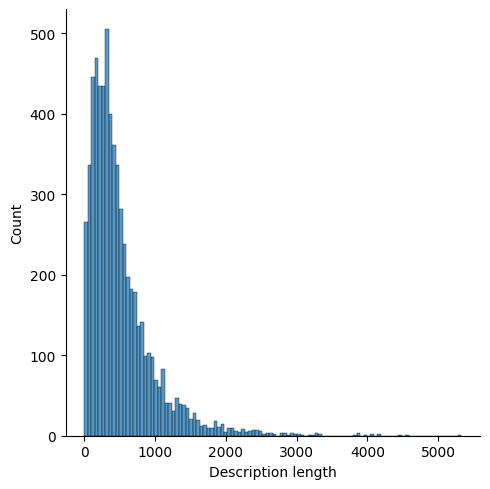

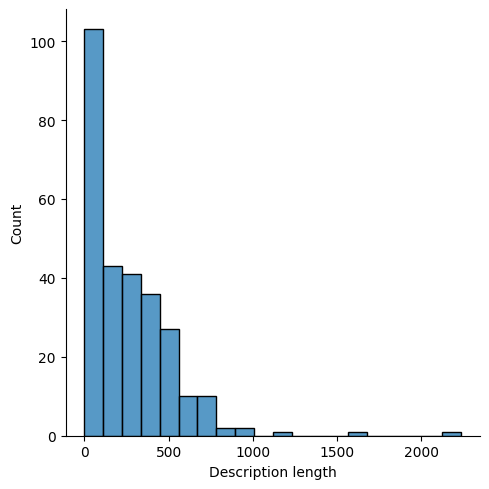

In [ ]:
records['Description length'] = records.description.apply(len)
sns.displot(records, x='Description length')

taxonomy['Description length'] = taxonomy.description.apply(len)
sns.displot(taxonomy, x='Description length')

records = records.drop(['Description length'], axis=1)
taxonomy = taxonomy.drop(['Description length'], axis=1)

## Preprocessing

In [ ]:
# Remove empty description
print('Length of records:', len(records))
print('Length of taxonomy', len(taxonomy))
indices = []
for index, row in records.iterrows():
    if row['description'] == '':
        indices.append(index)

records = records.drop(records.index[indices])
records.reset_index(drop=True, inplace=True)

indices = []
for index, row in taxonomy.iterrows():
    if row['description'] == '':
        indices.append(index)

taxonomy = taxonomy.drop(taxonomy.index[indices])
taxonomy.reset_index(drop=True, inplace=True)

print('Length of records:', len(records))
print('Length of taxonomy', len(taxonomy))

Length of records: 6406
Length of taxonomy 277
Length of records: 6239
Length of taxonomy 193


In [ ]:
def cleanhtml(raw_html):
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

records['description'] = records['description'].apply(lambda x: cleanhtml(x))
taxonomy['description'] = taxonomy['description'].apply(lambda x: cleanhtml(x))

## Word Embedding

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Embed descriptions

In [ ]:
records_description = records['description'].tolist()
taxonomy_description = taxonomy['description'].tolist()

In [ ]:
records_embeddings = []
for i in range(len(records_description)):
    tokenized_record = tokenizer(records_description[i], padding='max_length', max_length=128, truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        embedding = model(input_ids=tokenized_record['input_ids'],
                        attention_mask=tokenized_record['attention_mask'],
                        token_type_ids=tokenized_record['token_type_ids'])
        embedding = embedding.last_hidden_state.mean(dim=1).cpu().numpy()

        records_embeddings.append(embedding)

taxonomy_embeddings = []
for i in range(len(taxonomy_description)):
    tokenized_taxonomy = tokenizer(taxonomy_description[i], padding='max_length', max_length=128, truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        embedding = model(input_ids=tokenized_taxonomy['input_ids'],
                        attention_mask=tokenized_taxonomy['attention_mask'],
                        token_type_ids=tokenized_taxonomy['token_type_ids'])
        embedding = embedding.last_hidden_state.mean(dim=1).cpu().numpy()

        taxonomy_embeddings.append(embedding)

### Embed user input

In [ ]:
def get_highest_numbers_with_indices(numbers, n=10):
    """
    Returns the n highest numbers in a list along with their indices.
    :param numbers: List of numbers
    :param n: Number of highest numbers to retrieve (default: 10)
    :return: List of tuples containing the highest numbers and their indices
    """
    highest_numbers_with_indices = []
    for i, num in enumerate(numbers):
        if len(highest_numbers_with_indices) < n:
            highest_numbers_with_indices.append((num, i))
            highest_numbers_with_indices.sort(reverse=True)
        else:
            if num > highest_numbers_with_indices[-1][0]:
                highest_numbers_with_indices.pop()
                highest_numbers_with_indices.append((num, i))
                highest_numbers_with_indices.sort(reverse=True)
    return highest_numbers_with_indices

In [ ]:
user_input = 'How to treat Obsessive Compulsive Disorder?'

token = tokenizer(user_input, padding='max_length', max_length=400, truncation=True, return_tensors='pt').to(device)
with torch.no_grad():
    result = model(token['input_ids'], attention_mask=token['attention_mask'])
    embedding = result.last_hidden_state.mean(dim=1).cpu().numpy()

### Get 10 most similar from records table

In [ ]:
similarity_lst = []
for i in range(len(records_embeddings)):
    similarity_lst.append(cosine_similarity(embedding, records_embeddings[i].reshape(1,-1))[0][0])

lst = get_highest_numbers_with_indices(similarity_lst)

for each in lst:
    print('Record id: %d,\nDescription: %s,\nSimilarity score: %5f\n' % (each[1], records['description'][each[1]], each[0]))

Record id: 5132,
Description: Proving trusted exposure and ritual prevention for the treatment of obsessive-compulsive disorder across the lifespan.,
Similarity score: 0.846985

Record id: 3054,
Description: Providing counseling to individuals in French and English, regarding depression, anxiety, stress, relationship issues, body image.,
Similarity score: 0.832399

Record id: 4534,
Description: Private practice clinic of psychologists offering adult therapy for most mental health issues. 

We also provide adult and child assessments for learning disabilities:

IQ, 
ADHD, 
Academic Issues.
Dyslexia,
Similarity score: 0.828712

Record id: 5372,
Description: Helping clients learn to love themselves by combatting negative self talk.,
Similarity score: 0.827247

Record id: 3272,
Description: Provides comprehensive diagnostic assessment and consultation for children/youth with complex symptoms that suggest a query of a mood and/or anxiety disorder.,
Similarity score: 0.826718

Record id: 330

### Get 10 most similar from taxonomy table

In [ ]:
similarity_lst = []
for i in range(len(taxonomy_embeddings)):
    similarity_lst.append(cosine_similarity(embedding, taxonomy_embeddings[i].reshape(1,-1))[0][0])

lst = get_highest_numbers_with_indices(similarity_lst)

for each in lst:
    print('Taxonomy id: %d,\nDescription: %s,\nSimilarity score: %5f\n' % (each[1], taxonomy['description'][each[1]], each[0]))

Taxonomy id: 171,
Description: 
	Neurofeedback isaway of dealing with various brain conditions (such as ADHD, depression, anxiety) by teaching the person to control and self-regulate their brain.,
Similarity score: 0.838439

Taxonomy id: 104,
Description: 
	Therapeutic Boarding Schools offer additional supports for teens that are struggling with problems with emotions, behaviour or self-esteem and motivation.,
Similarity score: 0.807461

Taxonomy id: 119,
Description: 
	See Eating Disorders including Anorexia and Bulimia,
Similarity score: 0.805234

Taxonomy id: 117,
Description: 
	See Eating Disorders including Anorexia and Bulimia,
Similarity score: 0.805234

Taxonomy id: 146,
Description: 
	Resources for people with mental health needs who are having problems with the law.,
Similarity score: 0.800562

Taxonomy id: 120,
Description: 
	Living with cancer can mean living with a wide range of emotions and psychological stresses that can have an impact on mental health and well-being.,
S